## 1. Introduction to the Butler
First, we need to import necessary packages to use the butler to access images.

In [5]:
# Import general Python packages used by scientists
import numpy
import matplotlib
import matplotlib.pyplot as plt

# Import packages for Image Access
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay

### 1.1 Initializing the Butler
Next, we create an instance of the Butler. 

In [6]:
butler = dafButler.Butler('/data/butler/dmu4')

Currently, the butler at somerville is populated with deep coadds generated by the lsst-ir fussion pipeline, using data from HSC and VISTA. More information about the pipeline can be found in <a href="https://github.com/lsst-uk/lsst-ir-fusion/tree/master">this github repo</a>. 

### 1.2 What is in the Butler?
Let's inspect the Butler. Metadata about what's in the Butler can be found on the registry.

In [7]:
registry = butler.registry

The Butler contains several collections: deepCoadds for VIDEO, VHS and VIKING, and a collection with the skymap definition.

In [8]:
for c in sorted(registry.queryCollections()):
    print(c)

VIRCAM/defaults
VIRCAM/runs/vhsCoaddDetect
VIRCAM/runs/videoCoaddDetect
VIRCAM/runs/vikingCoaddDetect
skymaps
u/ir-shir1/DRP/vhsCoaddDetect/20221209T131239Z
u/ir-shir1/DRP/videoCoaddDetect/20221130T131608Z
u/ir-shir1/DRP/vikingCoaddDetect/20230110T180302Z


We can also query for collections with a particular keyword.

In [9]:
for c in sorted(registry.queryCollections("*video*")):
    print(c)

VIRCAM/runs/videoCoaddDetect
u/ir-shir1/DRP/videoCoaddDetect/20221130T131608Z


Collections contain datasets, which are simply files. Each dataset has a specific dataset type.

In [10]:
for dt in sorted(registry.queryDatasetTypes()):
    print(dt)

DatasetType('deepCoadd_calexp', {band, skymap, tract, patch}, ExposureF)
DatasetType('skyMap', {skymap}, SkyMap)


We can see that each DatasetType contains three fields: the name of the type, the dimensions of that type and the class in which the type is stored. 

In [11]:
dt = registry.getDatasetType('deepCoadd_calexp')
print("Name:", dt.name)
print("Dimensions:", dt.dimensions)
print("Storage Class:", dt.storageClass)

Name: deepCoadd_calexp
Dimensions: {band, skymap, tract, patch}
Storage Class: ExposureF


To inspect a particular dimension:

In [12]:
print(butler.registry.dimensions['patch'].RecordClass.fields)

patch: 
  skymap: str
  tract: int
  id: int
  cell_x: int
  cell_y: int
  region: lsst.sphgeom.Region


In [13]:
video='u/ir-shir1/DRP/videoCoaddDetect/20221130T131608Z'

In [14]:
datasetType = 'deepCoadd_calexp'
dataId={'tract':8525,'patch':70,'skymap':'hscPdr2'}
datasetRefs = set(registry.queryDatasets(datasetType, dataId=dataId,collections=video))
for i, ref in enumerate(datasetRefs):
    print(ref.dataId.full)
        
print(f"Found {len(datasetRefs)} bands")

{band: 'H', skymap: 'hscPdr2', tract: 8525, patch: 70}
{band: 'Y', skymap: 'hscPdr2', tract: 8525, patch: 70}
{band: 'K', skymap: 'hscPdr2', tract: 8525, patch: 70}
{band: 'Z', skymap: 'hscPdr2', tract: 8525, patch: 70}
{band: 'J', skymap: 'hscPdr2', tract: 8525, patch: 70}
Found 5 bands


### 1.3 Identify and retrieve a deepCoadd

There is a  JKCS 041 cluster of galaxies at right ascension 2h 26m 44s declination −04° 41′ 37″ (J2000.0) (36.687745, -4.6940845 in degrees). We can use <a href="https://pipelines.lsst.io/modules/lsst.geom/index.html">lsst.geom</a> to define a SpherePoint for the cluster's coordinates:

In [15]:
my_ra_deg = 36.687745
my_dec_deg = -4.6940845
my_spherePoint = lsst.geom.SpherePoint(my_ra_deg*lsst.geom.degrees,
                                       my_dec_deg*lsst.geom.degrees)
print(my_spherePoint)

(36.6877450000, -4.6940845000)


To identify the tract and patch that we need to query for, we need to retrieve the skymap.

In [16]:
skymap = butler.get('skyMap', {'skymap':'hscPdr2'},collections='skymaps')
tract = skymap.findTract(my_spherePoint)
patch = tract.findPatch(my_spherePoint)

my_tract = tract.tract_id
my_patch = patch.getSequentialIndex()

print('my_tract: ', my_tract)
print('my_patch: ', my_patch)

my_tract:  8525
my_patch:  70


Now we can use this information to query the butler and retrieve a coadd for the specific tract and patch. Let's get a deep Z-band coadd:

In [17]:
band='Z'
my_deepCoadd = butler.get('deepCoadd_calexp', band='Z', tract=my_tract, patch=my_patch, skymap='hscPdr2',collections=video)

### 1.4 Display the image with afwDisplay
The simplest way to display images retrieved from the butler is to use the LSST Science Pipelines package <a href="https://pipelines.lsst.io/modules/lsst.afw.display/index.html">afwDisplay</a>. We first need to set the backend of afwDisplay, in this case we will use matplotlib.

In [18]:
afwDisplay.setDefaultBackend('matplotlib')

Now we can create a figure and plot the retrieved coadd in it:

(27899.5, 32099.5, 27899.5, 32099.5)

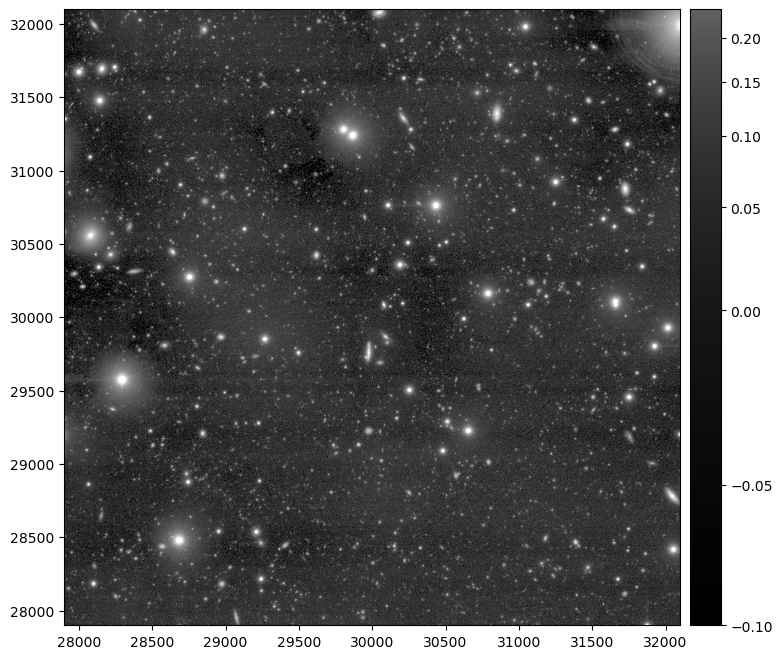

In [19]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(1)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(my_deepCoadd.image)
plt.gca().axis('on')